In [1]:
import torch

## Render our simple world with no pendulum (it's empty)


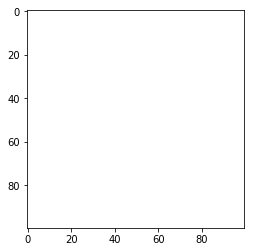

In [2]:
img = torch.zeros((100,100))

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()

## Get a state of the pendulum

<p align="center">
  <img src="simple_pend.svg" width="250"/>
</p>

In [3]:
## parameters

l = 30.0   # length in pixels
g = 9.8    # gravity in m/s**2

## state

theta    = 1.0 # angle from down
thetadot = 0 # 

state = torch.FloatTensor([theta, thetadot])
print state


 1
 0
[torch.FloatTensor of size 2]



## Convert state of pendulum to line segment

In [4]:
base = torch.FloatTensor([0,0])  # in world coordinates

def convert_world_to_img_coordinates(world_coordinates):
    return world_coordinates + 50


base_in_img = convert_world_to_img_coordinates(base)


length_x = l * torch.cos(state[0:1])
length_y = l * torch.sin(state[0:1])

length = torch.cat((length_x, length_y))

end = base + length
end_in_img = convert_world_to_img_coordinates(end)

## Find all pixels close enough to line segment


In [5]:
import numpy as np
pi = np.pi

In [6]:
def torch_flip(two_element_tensor):
    return torch.FloatTensor([two_element_tensor[1],two_element_tensor[0]])
    
def torch_det(A,B):
    return A[0]*B[1] - A[1]*B[0]


def distance_pytorch(A, B, P):
    if (A == B).all() or (B == P).all():
        return 0
    if (torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), 
                                                (B - A) / (B - A).norm())])) > pi/2).all():
        return (P - A).norm()
    
    if (torch.acos(torch.FloatTensor([torch.dot((P - B) / (P - B).norm(), 
                                                (A - B) / (A - B).norm())])) > pi/2).all():
        return (P - B).norm()
    
    return abs(torch_det(A-B, A-P))/(B-A).norm()


 50
 50
[torch.FloatTensor of size 2]


 66.2091
 75.2441
[torch.FloatTensor of size 2]



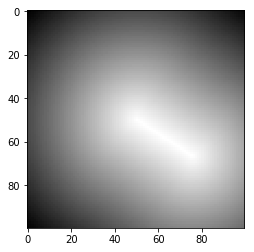

In [7]:
print base_in_img
print end_in_img

img = torch.zeros((100,100))

for i, row in enumerate(img):
    for j, val in enumerate(row):
        this_img_coord = torch.FloatTensor([i,j])
        img[i,j] = distance_pytorch(base_in_img, end_in_img, this_img_coord)

plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()

## Render pendulum

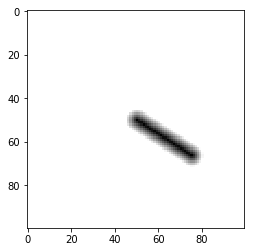

In [8]:
img = torch.zeros((100,100))

for i, row in enumerate(img):
    for j, val in enumerate(row):
        this_img_coord = torch.FloatTensor([i,j])
        dist = distance_pytorch(base_in_img, end_in_img, this_img_coord)
        if dist < 5.0:
            img[i,j] = 5 - dist

plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()


## Get states of pendulum over time

In [9]:
## parameters

l = 30.0   # length in pixels
g = 9.8    # gravity in m/s**2
m = 1.0    # mass in kg
b = 10.0    # damping

## initial state

theta    = 1.0 # angle from down
thetadot = 0 # 

state = torch.FloatTensor([theta, thetadot])

def pendulum_next_state(state, u):
    deriv = torch.zeros(2)
    deriv[0] = state[1]
    deriv[1] = float(-(m * g * l * torch.sin(state[0:1])) - b*state[1])
    dt = .01
    next_state = state + deriv*dt
    return next_state

print state
print pendulum_next_state(state,0)
print pendulum_next_state(state,0)
print pendulum_next_state(pendulum_next_state(state,0),0)

state_tape = []
state_tape.append(state)

for i in range(10):
    next_state = pendulum_next_state(state_tape[-1],0)
    state_tape.append(next_state)
    
print len(state_tape)

print state_tape[1]
print state_tape[6]


 1
 0
[torch.FloatTensor of size 2]


 1.0000
-2.4739
[torch.FloatTensor of size 2]


 1.0000
-2.4739
[torch.FloatTensor of size 2]


 0.9753
-4.7005
[torch.FloatTensor of size 2]

11

 1.0000
-2.4739
[torch.FloatTensor of size 2]


  0.6806
-10.8365
[torch.FloatTensor of size 2]



In [10]:
base = torch.FloatTensor([0,0])  # in world coordinates
base_in_img = convert_world_to_img_coordinates(base)

def pendulum_state_to_img(state):
    length_x = l * torch.cos(state[0:1])
    length_y = l * torch.sin(state[0:1])

    length = torch.cat((length_x, length_y))

    end = base + length
    end_in_img = convert_world_to_img_coordinates(end)
    
    img = torch.zeros((100,100))

    for i, row in enumerate(img):
        for j, val in enumerate(row):
            this_img_coord = torch.FloatTensor([i,j])
            dist = distance_pytorch(base_in_img, end_in_img, this_img_coord)
            if dist < 5.0:
                img[i,j] = 5 - dist

    return img


img_tape = []

for i in state_tape:
    img_tape.append(pendulum_state_to_img(i))
    
print len(img_tape)

11


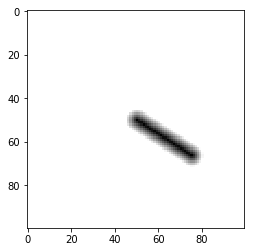

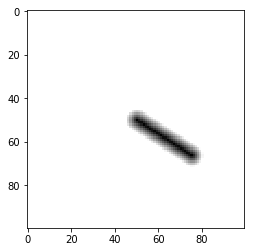

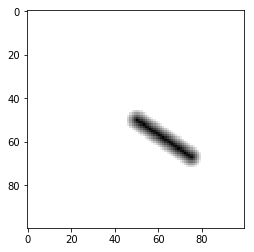

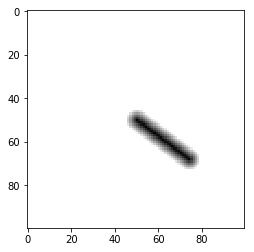

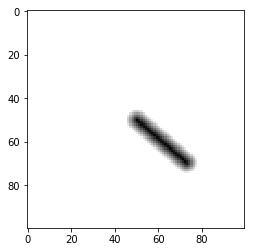

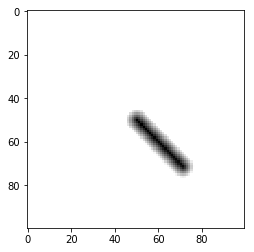

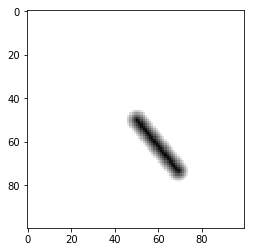

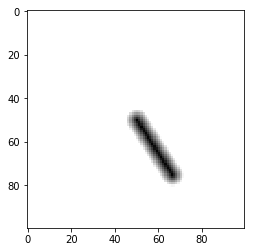

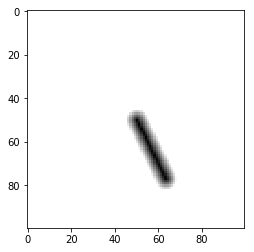

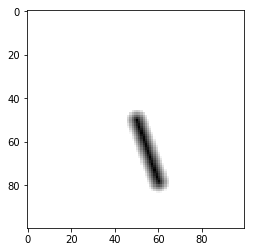

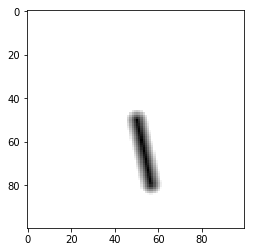

In [11]:
%matplotlib inline
for i in img_tape:
    plt.imshow(i, cmap=plt.get_cmap('gray_r'))
    plt.show()

In [21]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

<IPython.core.display.Javascript object>


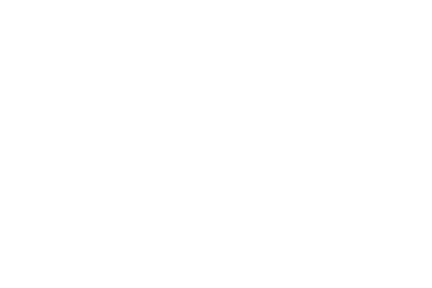

In [33]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation

fig = plt.figure()
first_img = img_tape[0]
im = plt.imshow(first_img, cmap='gist_gray_r')

def init():
    im.set_data(first_img)

def animate(i):
    im.set_data(img_tape[i])
    return im
    
animate = animation.FuncAnimation(fig, animate, init_func=init, frames=len(img_tape), interval=20, blit=True)
plt.close(fig)
display_animation(animate)

<IPython.core.display.Javascript object>


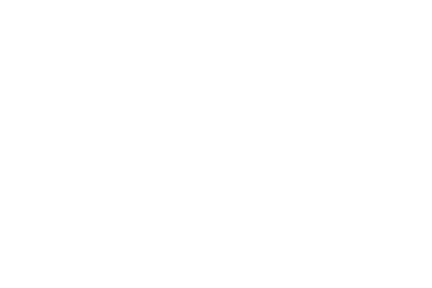

In [37]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation

fig = plt.figure()
first_img = img_tape[0]
im = plt.imshow(first_img, cmap='gist_gray_r')

def init():
    im.set_data(first_img)

def animate(i):
    im.set_data(img_tape[i])
    return im
    
animate = animation.FuncAnimation(fig, animate, init_func=init, frames=len(img_tape), interval=50, blit=True)
plt.close(fig)
HTML(animate.to_html5_video())

In [14]:
# good pendulum examples from
# from https://gist.github.com/AndrewWalker/2687988

<IPython.core.display.Javascript object>


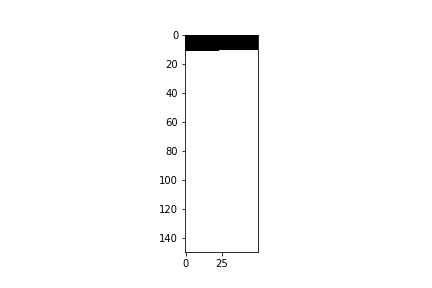

In [18]:
# import numpy as np
# from matplotlib import pyplot as plt
# from matplotlib import animation

# nx = 150
# ny = 50

# fig = plt.figure()
# data = np.zeros((nx, ny))
# im = plt.imshow(data, cmap='gist_gray_r', vmin=0, vmax=1)

# def init():
#     im.set_data(np.zeros((nx, ny)))

# def animate(i):
#     xi = i // ny
#     yi = i % ny
#     data[xi, yi] = 1
#     im.set_data(data)
#     return im

# anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nx * ny,
#                                interval=1)

In [1]:
import matplotlib.pyplot as plt, mpld3
plt.plot([3,1,4,1,5], 'ks-', mec='w', mew=5, ms=20)
mpld3.show()

ImportError: No module named mpld3

<IPython.core.display.Javascript object>


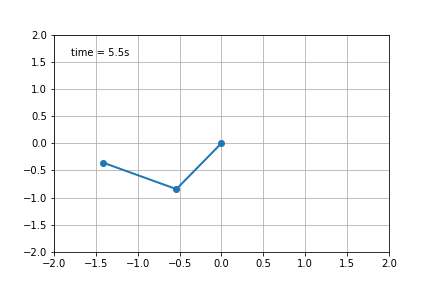

In [18]:
"""
===========================
The double pendulum problem
===========================

This animation illustrates the double pendulum problem.
"""

# Double pendulum formula translated from the C code at
# http://www.physics.usyd.edu.au/~wheat/dpend_html/solve_dpend.c

from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg


def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_)
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0.0, 20, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=25, blit=True, init_func=init)

# ani.save('double_pendulum.mp4', fps=15)
plt.show()